0. Libraries

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rice, uniform
from scipy import ndimage
import time
import os

1. SETUP: Paths, Metadata, and Helper Functions

In [52]:
# --- TO DO: Update these paths ---
IMAGE_DIR = '../images'
TARGET_DIR = '../target_lists'
PARAM_DIR = 'parameter_maps' # Directory to save/load MLE results

# Create parameter map directory if it doesn't exist
if not os.path.exists(PARAM_DIR):
    os.makedirs(PARAM_DIR)

# --- Metadata for all 24 images (from previous steps) ---
image_metadata = [
    # Mission 2: Deployment "Sigismund"
    {'mission': 2, 'pass': 1, 'heading': 225, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 2, 'heading': 135, 'deployment': 'Sigismund', 'rfi': 0, 'filename': 'v02_2_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 3, 'heading': 225, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 4, 'heading': 135, 'deployment': 'Sigismund', 'rfi': 0, 'filename': 'v02_2_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 5, 'heading': 230, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 6, 'heading': 230, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 3: Deployment "Karl"
    {'mission': 3, 'pass': 1, 'heading': 225, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_1_2.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 2, 'heading': 135, 'deployment': 'Karl', 'rfi': 0, 'filename': 'v02_3_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 3, 'heading': 225, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 4, 'heading': 135, 'deployment': 'Karl', 'rfi': 0, 'filename': 'v02_3_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 5, 'heading': 230, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_5_2.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 6, 'heading': 230, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 4: Deployment "Fredrik"
    {'mission': 4, 'pass': 1, 'heading': 225, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 2, 'heading': 135, 'deployment': 'Fredrik', 'rfi': 0, 'filename': 'v02_4_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 3, 'heading': 225, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 4, 'heading': 135, 'deployment': 'Fredrik', 'rfi': 0, 'filename': 'v02_4_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 5, 'heading': 230, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 6, 'heading': 230, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 5: Deployment "Adolf-Fredrik"
    {'mission': 5, 'pass': 1, 'heading': 225, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 2, 'heading': 135, 'deployment': 'Adolf-Fredrik', 'rfi': 0, 'filename': 'v02_5_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 3, 'heading': 225, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 4, 'heading': 135, 'deployment': 'Adolf-Fredrik', 'rfi': 0, 'filename': 'v02_5_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 5, 'heading': 230, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 6, 'heading': 230, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_6_1.a.Fbp.RFcorr.Geo.Magn'},
]
epsilon = 1e-9 # Small constant to prevent division by zero or log(0)

def load_sar_image(filename, directory, rows=3000, cols=2000):
    """Reads a raw 32-bit big-endian float CARABAS-II image file."""
    filepath = os.path.join(directory, filename)
    image_data = np.fromfile(filepath, dtype='>f4').reshape((rows, cols))
    return image_data

def load_ground_truth_pixels(deployment_name, target_dir):
    """Loads and converts ground truth coordinates to pixel locations."""
    target_filename = deployment_name + ".Targets.txt"
    target_filepath = os.path.join(target_dir, target_filename)
    
    ground_truth_geo = np.loadtxt(target_filepath, usecols=(0, 1))
    
    # Constants from data_description.pdf
    Nmax, Emin = 7370488, 1653166
    
    ground_truth_pixels = []
    for north, east in ground_truth_geo:
        row = int(round(Nmax - north))
        col = int(round(east - Emin))
        ground_truth_pixels.append((row, col))
        
    return ground_truth_pixels

def evaluate_performance(detection_map, ground_truth_pixels):
    """Calculates Pd and FAR for a given detection map."""
    # Post-process the map: one erosion, two dilations
    eroded_map = ndimage.binary_erosion(detection_map)
    processed_map = ndimage.binary_dilation(eroded_map, iterations=2)
    
    # Find the center of each detected object
    labeled_map, num_objects = ndimage.label(processed_map)
    if num_objects == 0:
        return 0.0, 0.0 # No detections, so Pd=0 and FAR=0
        
    detected_centers = ndimage.center_of_mass(processed_map, labeled_map, range(1, num_objects + 1))
    
    # Match detections to ground truth targets
    match_radius = 10.0
    true_positives = 0
    unmatched_detections = list(detected_centers)
    num_true_targets = len(ground_truth_pixels)
    
    for true_target_pos in ground_truth_pixels:
        for i, detected_pos in enumerate(unmatched_detections):
            distance = np.sqrt((true_target_pos[0] - detected_pos[0])**2 + (true_target_pos[1] - detected_pos[1])**2)
            if distance <= match_radius:
                true_positives += 1
                unmatched_detections.pop(i)
                break
    
    false_positives = len(unmatched_detections)
    image_area_km2 = 6.0
    
    pd = true_positives / num_true_targets if num_true_targets > 0 else 0.0
    far = false_positives / image_area_km2
    
    # print(true_positives,false_positives)
    
    return pd, far

2. Data Preparation

In [53]:
print("--- Data Preparation ---")
# Select surveillance image and build background stack
surveillance_info = image_metadata[0]
background_stack_info = [
    img for img in image_metadata
    if img['heading'] == surveillance_info['heading']
    and img['deployment'] != surveillance_info['deployment']
]

print(f"Surveillance Image: {surveillance_info['filename']}")
surveillance_image = load_sar_image(surveillance_info['filename'], IMAGE_DIR)
background_images = [load_sar_image(info['filename'], IMAGE_DIR) for info in background_stack_info]
background_stack = np.stack(background_images, axis=0)

# Load ground truth for this surveillance image
ground_truth = load_ground_truth_pixels(surveillance_info['deployment'], TARGET_DIR)
print(f"Loaded {len(ground_truth)} ground truth targets for {surveillance_info['deployment']}.\n")

--- Data Preparation ---
Surveillance Image: v02_2_1_1.a.Fbp.RFcorr.Geo.Magn
Loaded 25 ground truth targets for Sigismund.



3. Rician Background Modeling (MLE)

In [54]:
print("--- Rician Background Modeling ---")
B_MAP_FILE = os.path.join(PARAM_DIR, 'b_map.npy')
LOC_MAP_FILE = os.path.join(PARAM_DIR, 'loc_map.npy')
SCALE_MAP_FILE = os.path.join(PARAM_DIR, 'scale_map.npy')

if os.path.exists(B_MAP_FILE):
    print("Loading pre-calculated Rician parameter maps...")
    b_map = np.load(B_MAP_FILE)
    loc_map = np.load(LOC_MAP_FILE)
    scale_map = np.load(SCALE_MAP_FILE)
else:
    print("Performing Rician MLE fit for the entire image. THIS WILL TAKE SEVERAL HOURS.")
    start_time = time.time()
    rows, cols = surveillance_image.shape
    b_map, loc_map, scale_map = np.zeros((3, rows, cols))
    
    for r in range(rows):
        for c in range(cols):
            pixel_data = background_stack[:, r, c]
            b, loc, scale = rice.fit(pixel_data, floc=0)
            b_map[r, c], loc_map[r, c], scale_map[r, c] = b, loc, scale
        if (r + 1) % 10 == 0:
            elapsed = time.time() - start_time
            print(f"Processed row {r+1}/{rows}... Time: {elapsed/60:.2f} min.")
    
    print("MLE fitting complete. Saving maps to disk...")
    np.save(B_MAP_FILE, b_map)
    np.save(LOC_MAP_FILE, loc_map)
    np.save(SCALE_MAP_FILE, scale_map)

# --- THE FIX: REGULARIZE THE MODEL ---
# Enforce a minimum standard deviation (scale) to prevent unstable statistics.
# This is a crucial step to make the model robust.
MIN_SCALE = 0.01 
scale_map = np.maximum(scale_map, MIN_SCALE)

print("Background model is ready.\n")

--- Rician Background Modeling ---
Loading pre-calculated Rician parameter maps...


Background model is ready.



4. ROC Curve Generation

In [57]:
print("--- ROC Curve Generation ---")
# Define the thresholds to test
pfa_thresholds = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-10]
tau_thresholds = [1, 10, 100, 1000, 1e4, 1e5, 1e6]

npcbs_results = []
npc_results = []

# --- Method 1: NPCBS ---
print("Running NPCBS method for different P_FA thresholds...")
for p_fa in pfa_thresholds:
    detection_threshold = 1 - p_fa
    cdf_values = rice.cdf(surveillance_image, b_map, loc=loc_map, scale=(scale_map + epsilon))
    detection_map = cdf_values >= detection_threshold
    
    pd, far = evaluate_performance(detection_map, ground_truth)
    npcbs_results.append((far, pd))
    print(f"  P_FA={p_fa:.0e} -> Pd={pd:.2%}, FAR={far:.2f}")

# --- Method 2: NPC ---
print("\nRunning NPC method for different Tau thresholds...")
# Target model: Uniform distribution
a_min = 0.4 # From paper's suggestion
a_max = np.max(surveillance_image)

# Calculate PDFs (vectorized for speed)
p_background = rice.pdf(surveillance_image, b_map, loc=loc_map, scale=(scale_map + epsilon))
p_target = uniform.pdf(surveillance_image, loc=a_min, scale=(a_max - a_min))

# Likelihood Ratio
likelihood_ratio = p_target / (p_background + epsilon)

for tau in tau_thresholds:
    detection_map = likelihood_ratio >= tau
    pd, far = evaluate_performance(detection_map, ground_truth)
    npc_results.append((far, pd))
    print(f"  Tau={tau:.0e} -> Pd={pd:.2%}, FAR={far:.2f}")

--- ROC Curve Generation ---
Running NPCBS method for different P_FA thresholds...
  P_FA=1e-02 -> Pd=100.00%, FAR=959.67
  P_FA=1e-03 -> Pd=100.00%, FAR=225.17
  P_FA=1e-04 -> Pd=100.00%, FAR=63.83
  P_FA=1e-05 -> Pd=100.00%, FAR=21.83
  P_FA=1e-06 -> Pd=100.00%, FAR=7.83
  P_FA=1e-07 -> Pd=100.00%, FAR=4.00
  P_FA=1e-10 -> Pd=100.00%, FAR=0.50

Running NPC method for different Tau thresholds...
  Tau=1e+00 -> Pd=100.00%, FAR=27.67
  Tau=1e+01 -> Pd=100.00%, FAR=6.67
  Tau=1e+02 -> Pd=100.00%, FAR=3.00
  Tau=1e+03 -> Pd=100.00%, FAR=1.00
  Tau=1e+04 -> Pd=100.00%, FAR=0.50
  Tau=1e+05 -> Pd=100.00%, FAR=0.50
  Tau=1e+06 -> Pd=100.00%, FAR=0.33


5. Plotting the ROC Curve


--- Plotting ROC Curve ---


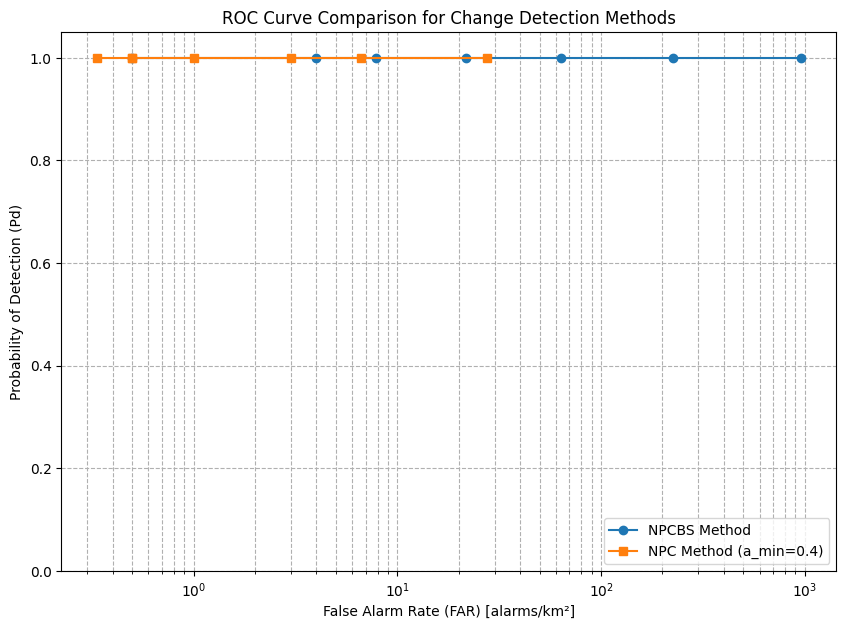

In [58]:
print("\n--- Plotting ROC Curve ---")
plt.figure(figsize=(10, 7))

# Unzip results for plotting
npcbs_far, npcbs_pd = zip(*npcbs_results)
npc_far, npc_pd = zip(*npc_results)

plt.plot(npcbs_far, npcbs_pd, 'o-', label='NPCBS Method')
plt.plot(npc_far, npc_pd, 's-', label='NPC Method (a_min=0.4)')

plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.xlabel('False Alarm Rate (FAR) [alarms/km²]')
plt.ylabel('Probability of Detection (Pd)')
plt.title('ROC Curve Comparison for Change Detection Methods')
plt.legend(loc='lower right')
plt.ylim(0, 1.05)
# plt.xlim(1e-2, 1e2) # Set x-axis limits similar to the paper
plt.show()